In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.tri as tri

import sys

sys.path.append("../code")

import sparseRRR
from plot_utils import adjust_spines

%load_ext jupyter_black

In [2]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2024-01-11 17:52:11WET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

sys       : 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
seaborn   : 0.12.2
pandas    : 2.0.3
matplotlib: 3.7.2
numpy     : 1.24.3

Watermark: 2.4.3



### Download data

In this notebook, we used some saved data uploaded to [Zenodo](https://zenodo.org/record/5118962). You can download them and place them under the folder `/data` manually, or just run the following cell:

In [3]:
def download_data():
    import os
    from zipfile import ZipFile

    cwd = os.getcwd()

    if os.path.exists("../data/SmartSeq_cells_AIBS.pickle"):
        print("Data exists.")
    else:
        os.chdir("../data/")
        !wget https://zenodo.org/record/5118962/files/reduced-allen-data.zip
        archive = ZipFile("../data/reduced-allen-data.zip", "r")
        archive.extractall(path="../data/")
        os.chdir(cwd)


download_data()

Data exists.


### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [4]:
M1_25degree = pickle.load(open("../code/pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [5]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [6]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [7]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [8]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

### Figure 4 and 5

We used sparse reduced-rank regression to predict model parameters from gene expression levels.

In [9]:
# Allen data t-type ordering:
allen = pickle.load(open("../data/SmartSeq_cells_AIBS.pickle", "rb"))
clusterNames = allen["neurons"]["clusterNames"]

/var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_4799/4175803554.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  allen = pickle.load(open("../data/SmartSeq_cells_AIBS.pickle", "rb"))


In [10]:
clusterNames[np.where(clusterNames == "L5 PT_1")[0]] = "L5 ET_1"
clusterNames[np.where(clusterNames == "L5 PT_2")[0]] = "L5 ET_2"
clusterNames[np.where(clusterNames == "L5 PT_3")[0]] = "L5 ET_3"
clusterNames[np.where(clusterNames == "L5 PT_4")[0]] = "L5 ET_4"

In [11]:
ttypes = []
for ttype in clusterNames:
    if ttype in celltypes.values:
        ttypes.append(ttype)
ttypes = np.array(ttypes)

In [12]:
fav_tr_schedule = "2d"

In [13]:
with open(
    "../code/save_model_parameters/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((13,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [14]:
data_exons = pd.read_csv(
    "../data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
IonChannelGenes = pd.read_csv(
    "../data/GO_term_summary_20211104_075621.txt", header=0, sep="\t"
)
selectedGenes = np.array(
    [
        (gene in IonChannelGenes["MGI Gene/Marker ID"].values)
        | (
            gene
            in [
                "Pvalb",
                "Lamp5",
                "Vip",
                "Sst",
            ]
        )
        for gene in data_exons.index
    ]
)
enough_counts = np.sum(data_exons, axis=1) >= 10
data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names[selectedGenes & enough_counts]

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [15]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

Depending on your machine, you might get slightly different weights. To produce the exact same embedding run the code in the 2nd block below.

In [16]:
### Uncomment to recompute

# w, v = sparseRRR.relaxed_elastic_rrr(
#     G,
#     highest_posterior_samples_standardized.astype(np.float64),
#     rank=2,
#     lambdau=0.189,
#     alpha=1,
# )

# save weights
# np.savez('./embedding_coordinates/sRRR.npz',
#      w=w,
#      v=v
#     )

In [17]:
# load weights
w = np.load("./embedding_coordinates/sRRR.npz")["w"]
v = np.load("./embedding_coordinates/sRRR.npz")["v"]

print("Genes selected: {}".format(np.sum(w[:, 0] != 0)))

Genes selected: 25


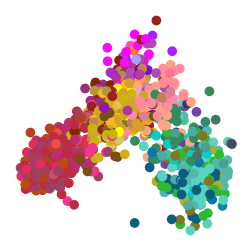

In [18]:
plt.figure(figsize=(3, 3))
plt.scatter((G @ w)[:, 0], (G @ w)[:, 1], c=colors)
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

#### Figure for new submission ?

Let us quantify the relationship better between fitted model parameters (MAP estimates) and those based on the prediction with gene expression values.

In [19]:
params_fitted = highest_posterior_samples.copy()

In [20]:
params_genes_predicted = (
    (G @ w @ v.T) * highest_posterior_samples.std(axis=0)
    + highest_posterior_samples.mean(axis=0)
).copy()

In [21]:
corrs = []
for i in range(len(model_param_names)):
    corrs.append(np.corrcoef(params_fitted[:, i], params_genes_predicted[:, i])[0, 1])

In [22]:
# corrs_Pyr = []
# for i in range(len(model_param_names)):
#    corrs_Pyr.append(
#        np.corrcoef(
#            params_fitted[celltype_Pyr, i], params_genes_predicted[celltype_Pyr, i]
#        )[0, 1]
#    )

In [23]:
# corrs_Pvalb = []
# for i in range(len(model_param_names)):
#    corrs_Pvalb.append(
#        np.corrcoef(
#            params_fitted[celltype_Pvalb, i], params_genes_predicted[celltype_Pvalb, i]
#        )[0, 1]
#    )

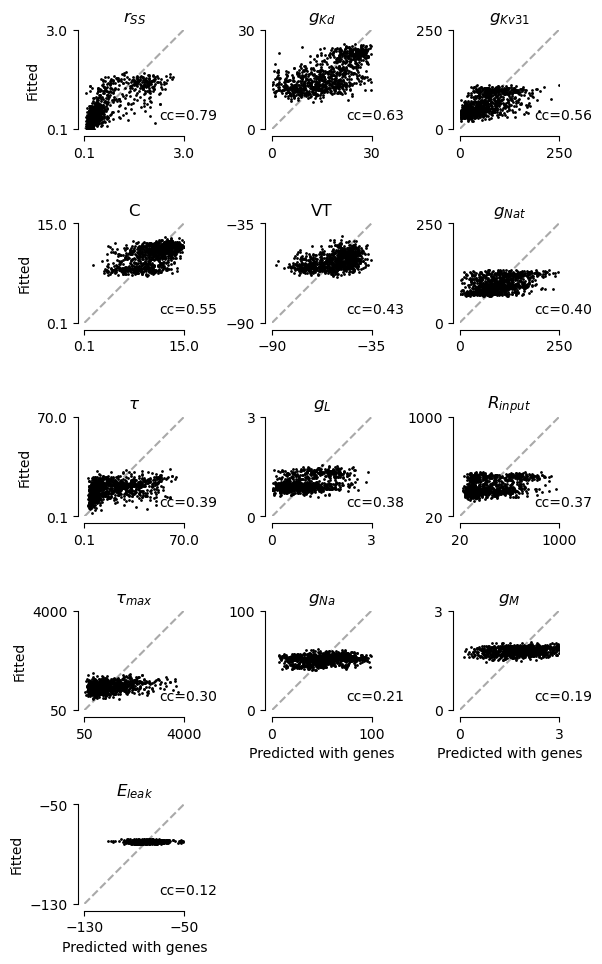

In [24]:
sorted = np.argsort(corrs)[::-1]

fig, axes = plt.subplots(5, 3, figsize=(6, 6 * 5 / 3))

for j, (i, ax) in enumerate(zip(sorted, axes.reshape(-1)[:-2])):
    ax.scatter(params_fitted[:, i], params_genes_predicted[:, i], c="k", s=1, zorder=1)
    ax.plot(
        [prior_min[i], prior_max[i]],
        [prior_min[i], prior_max[i]],
        "--",
        c="darkgrey",
        zorder=0,
    )
    ax.set_xlim((prior_min[i], prior_max[i]))
    ax.set_ylim((prior_min[i], prior_max[i]))
    ax.set_title(model_param_names[i])
    ax.set_xticks((prior_min[i], prior_max[i]))
    ax.set_yticks((prior_min[i], prior_max[i]))
    sns.despine(ax=ax)
    adjust_spines(ax, ["left", "bottom"])
    ax.set_aspect("equal")
    ax.annotate("cc={:.2f}".format(corrs[i]), xy=(0.75, 0.1), xycoords="axes fraction")

for ax in axes.reshape(-1)[-2:]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(left=True, bottom=True, ax=ax)

for ax in [axes[0, 0], axes[1, 0], axes[2, 0], axes[3, 0], axes[4, 0]]:
    ax.set_ylabel("Fitted")

for ax in [axes[4, 0], axes[3, 1], axes[3, 2]]:
    ax.set_xlabel("Predicted with genes")

plt.tight_layout()

plt.savefig("figure_x1.png", bbox_inches="tight", pad_inches=0)

In [25]:
# fig, axes = plt.subplots(5, 3, figsize=(6, 6 * 5 / 3))
# for j, (i, ax) in enumerate(zip(sorted, axes.reshape(-1)[:-2])):
#    ax.scatter(
#        params_fitted[celltype_Pvalb.values, i],
#        params_genes_predicted[celltype_Pvalb.values, i],
#        c="k",
#        s=1,
#        zorder=1,
#    )
#    ax.plot(
#        [prior_min[i], prior_max[i]],
#        [prior_min[i], prior_max[i]],
#        "--",
#        c="darkgrey",
#        zorder=0,
#    )
#    ax.set_xlim((prior_min[i], prior_max[i]))
#    ax.set_ylim((prior_min[i], prior_max[i]))
#    ax.set_title(model_param_names[i])
#    ax.set_xticks((prior_min[i], prior_max[i]))
#    ax.set_yticks((prior_min[i], prior_max[i]))
#    sns.despine(ax=ax)
#    adjust_spines(ax, ["left", "bottom"])
#    ax.set_aspect("equal")
#    ax.annotate(
#        "cc={:.2f}".format(corrs_Pvalb[i]), xy=(0.75, 0.1), xycoords="axes fraction"
#    )
#
# for ax in axes.reshape(-1)[-2:]:
#    ax.set_xticks([])
#    ax.set_yticks([])
#    sns.despine(left=True, bottom=True, ax=ax)
#
# for ax in [axes[0, 0], axes[1, 0], axes[2, 0], axes[3, 0], axes[4, 0]]:
#    ax.set_ylabel("Fitted")
#
# for ax in [axes[4, 0], axes[3, 1], axes[3, 2]]:
#    ax.set_xlabel("Predicted with genes")
#
# plt.tight_layout()